# Stacking Models

Stacking is an ensemble learning method that combines multiple classification models to improve predictive performance. It works in two stages:

1. Train multiple base models on the dataset.
2. Use their predictions to train a meta-model, which learns how to best combine them.

This notebook implements a stacking approach using K-Nearest Neighbors, Decision Tree, and Random Forest as base models. Their predictions are then used to train a Naive Bayes classifier as the meta-model. The performance of the stacking model is compared to that of the individual models using accuracy and ROC curves.

### Importing modules

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc

np.random.seed(42)

### Retrieval

The dataset is loaded from two sources:

- Cleaned Raw Data: The original training and testing sets after preprocessing.
- Cleaned Oversampled Data: A version of the dataset where oversampling techniques (e.g., SMOTE) have been applied to address class imbalance.

Using both datasets allows us to compare how models perform on naturally imbalanced data versus balanced data. This helps evaluate model robustness and fairness in prediction accuracy across different class distributions.

In [122]:
df_raw = pd.read_csv("data/alzheimers_disease_data.csv")
df_oversampled = pd.read_csv("data/alzheimers_disease_data_oversampled.csv")

df_raw = df_raw.drop(columns=['PatientID', 'DoctorInCharge'])
df_oversampled = df_oversampled.drop(columns=['PatientID', 'DoctorInCharge'])

print(df_raw.shape)
print(df_oversampled.shape)

(2149, 33)
(2778, 33)


In [123]:
df_raw.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [124]:
df_oversampled.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


### Split

The dataset is divided into training and testing sets for both raw and oversampled versions. This separation ensures that model evaluation is performed on unseen data, allowing us to assess generalization performance. The same split is applied consistently across models to maintain comparability.


In [ ]:
def split_data(df):
    df_processed = df.copy()

    X = df_processed.drop(columns=['Diagnosis'])
    y = df_processed['Diagnosis']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

X_train_raw, X_test_raw, y_train_raw, y_test_raw, X_train_scaled_raw, X_test_scaled_raw, scaler_raw = split_data(df_raw)
X_train_os, X_test_os, y_train_os, y_test_os, X_train_scaled_os, X_test_scaled_os, scaler_os = split_data(df_oversampled)

### Models selection

This function automates the training and evaluation process for KNN, Decision Tree, and Random Forest classifiers. It compares model performance on both raw and oversampled datasets using cross-validation or out-of-bag scores (for Random Forest). The model that achieves higher accuracy on the test set is selected for further use. This ensures optimal performance based on the nature of the dataset.

In [158]:
def train_evaluate_select(model_name, model_instance_params,
                         X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
                         X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    if model_name == 'KNN':
        model_raw_instance = KNeighborsClassifier(**model_instance_params)
        model_os_instance = KNeighborsClassifier(**model_instance_params)

        cv_scores_raw = cross_val_score(model_raw_instance, X_train_scaled_raw, y_train_raw, 
                                        cv=cv, scoring='accuracy')
        cv_mean_raw = np.mean(cv_scores_raw)
        print("Cross-Validation Accuracy (Raw Data): " + str(round(cv_mean_raw, 4)))
        
        cv_scores_os = cross_val_score(model_os_instance, X_train_scaled_os, y_train_os, 
                                       cv=cv, scoring='accuracy')
        cv_mean_os = np.mean(cv_scores_os)
        print("Cross-Validation Accuracy (Oversampled Data): " + str(round(cv_mean_os, 4)))
    
        
    elif model_name == 'Random Forest':
        model_raw_instance = RandomForestClassifier(oob_score=True, **model_instance_params)
        model_os_instance = RandomForestClassifier(oob_score=True, **model_instance_params)

        model_raw_instance.fit(X_train_scaled_raw, y_train_raw)
        print("OOB Accuracy (Raw Data): " + str(round(model_raw_instance.oob_score_, 4)))
        
        model_os_instance.fit(X_train_scaled_os, y_train_os)
        print("OOB Accuracy (Oversampled Data): " + str(round(model_os_instance.oob_score_, 4)))
    
    else:
        model_raw_instance = DecisionTreeClassifier(**model_instance_params)
        model_os_instance = DecisionTreeClassifier(**model_instance_params)

        cv_scores_raw = cross_val_score(model_raw_instance, X_train_scaled_raw, y_train_raw, 
                                        cv=cv, scoring='accuracy')
        cv_mean_raw = np.mean(cv_scores_raw)
        print("Cross-Validation Accuracy (Raw Data): " + str(round(cv_mean_raw, 4)))
        
        cv_scores_os = cross_val_score(model_os_instance, X_train_scaled_os, y_train_os, 
                                       cv=cv, scoring='accuracy')
        cv_mean_os = np.mean(cv_scores_os)
        print("Cross-Validation Accuracy (Oversampled Data): " + str(round(cv_mean_os, 4)))
    
    model_raw_instance.fit(X_train_scaled_raw, y_train_raw)
    pred_raw = model_raw_instance.predict(X_test_scaled_raw)
    acc_raw = accuracy_score(y_test_raw, pred_raw)
    print("Test Accuracy (Raw Data): " + str(round(acc_raw, 4)))

    model_os_instance.fit(X_train_scaled_os, y_train_os)
    pred_os = model_os_instance.predict(X_test_scaled_os)
    acc_os = accuracy_score(y_test_os, pred_os)
    print("Test Accuracy (Oversampled Data): " + str(round(acc_os, 4)))

    if acc_os >= acc_raw:
        return model_os_instance, pred_os, acc_os, X_test_scaled_os, y_test_os, 'Oversampled'
    else:
        return model_raw_instance, pred_raw, acc_raw, X_test_scaled_raw, y_test_raw, 'Raw'



### KNN

In [159]:
knn_params = {'n_neighbors': 25}
knn_best, knn_pred_best, knn_acc_best, X_test_scaled_knn, y_test_knn, knn_dataset_type = train_evaluate_select(
    "KNN", knn_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

Cross-Validation Accuracy (Raw Data): 0.7254
Cross-Validation Accuracy (Oversampled Data): 0.7349
Test Accuracy (Raw Data): 0.7279
Test Accuracy (Oversampled Data): 0.7554


Based on the results, the oversampled dataset had a better performance in both cross-validation and test evaluation.

### Random Forest

In [160]:
rf_params = {'n_estimators': 100, 'random_state': 42}
rf_best, rf_pred_best, rf_acc_best, X_test_scaled_rf, y_test_rf, rf_dataset_type = train_evaluate_select(
    'Random Forest', rf_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

OOB Accuracy (Raw Data): 0.9348
OOB Accuracy (Oversampled Data): 0.9703
Test Accuracy (Raw Data): 0.9372
Test Accuracy (Oversampled Data): 0.973


The Random Forest model was trained and evaluated on both raw and oversampled datasets. One key feature of Random Forest is its use of Out-of-Bag (OOB) estimation, a built-in validation method. Since each tree in the forest is trained on a random bootstrap sample of the data, the unused samples (the “out-of-bag” instances) can be used to estimate performance without needing a separate validation set.

The model trained on the oversampled data outperformed the raw version across both OOB and test evaluations.

### Decision Tree

In [161]:
dt_params = {'random_state': 42}
dt_best, dt_pred_best, dt_acc_best, X_test_scaled_dt, y_test_dt, dt_dataset_type = train_evaluate_select(
    'Decision Tree', dt_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

Cross-Validation Accuracy (Raw Data): 0.8999
Cross-Validation Accuracy (Oversampled Data): 0.9298
Test Accuracy (Raw Data): 0.9
Test Accuracy (Oversampled Data): 0.9496


The model showed improved performance when trained on the oversampled data.

### Stacking Model

In this section, we create the "meta-features" for the stacking model. A stacking model combines predictions from several base models and uses them as features to train a final model, typically a simpler classifier. All of the models are trained on the oversampled dataset.

  
- We use cross-validation to generate predictions from the KNN and Decision Tree models. These predictions are stored as new features in the `meta_features_train` DataFrame. The predictions are generated using `cross_val_predict`, which returns the predicted labels for each data point based on the cross-validation procedure.
- Random Forest is trained on the oversampled training data. The model's out-of-bag (OOB) predictions are used as another meta-feature. OOB predictions provide an estimate of model performance without the need for a separate validation set.
- After generating the predictions from KNN, Decision Tree, and Random Forest, these are combined into a single DataFrame: `meta_features_train`. Those will serve as the input features for the final meta-model.
- The target variable `y_train_os` is added as the actual labels in the DataFrame for training the final meta-model.

In [162]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

meta_features_train = pd.DataFrame({
    'knn_pred': cross_val_predict(knn_best, X_train_scaled_os, y_train_os, cv=cv_strategy),
    'dt_pred': cross_val_predict(dt_best, X_train_scaled_os, y_train_os, cv=cv_strategy)
})

rf_best.fit(X_train_scaled_os, y_train_os)
rf_oob_predictions = rf_best.predict(X_train_scaled_os)

meta_features_train['rf_pred'] = rf_oob_predictions
meta_features_train['target'] = y_train_os.reset_index(drop=True)

meta_features_train


,knn_pred,dt_pred,rf_pred,target
0,0,0,0,0
1,1,1,1,1
2,0,1,1,1
3,1,1,1,1
4,0,0,0,0
...,...,...,...,...
2217,0,0,0,0
2218,1,1,1,1
2219,1,1,1,1
2220,0,0,0,0


In [163]:
gnb = GaussianNB()
gnb.fit(meta_features_train[['knn_pred', 'rf_pred', 'dt_pred']], meta_features_train['target'])

meta_features_test = pd.DataFrame({
    'knn_pred': knn_best.predict(X_test_scaled_os),
    'rf_pred': rf_best.predict(X_test_scaled_os),
    'dt_pred': dt_best.predict(X_test_scaled_os)
})

stack_pred = gnb.predict(meta_features_test)
stack_acc = accuracy_score(y_test_os, stack_pred)

print("Stacking Accuracy with Naive Bayes:", round(stack_acc, 4))

Stacking Accuracy with Naive Bayes: 0.973


In this section, we train the final meta-model using the predictions from the base models. The meta-model is a Gaussian Naive Bayes (GNB) classifier, which is trained on the meta-features generated in the previous step.

- We use the meta-features from the base models `'knn_pred'`, `'rf_pred'` and `'dt_pred'` along with the actual target values `'target'` to train the Naive Bayes model. This model learns how to combine the predictions from the base models and make its own prediction based on them.
- For the test dataset, we generate predictions from the base models using the trained models `knn_best`, `dt_best`, `rf_best`, similar to how we did for the training data.
- The meta-features for the test data are passed into the trained Naive Bayes classifier `gnb` to generate the final predictions `stack_pred`.
- We calculate the accuracy of the stacking model by comparing the predictions `stack_pred` with the true labels `y_test_os`. The accuracy score gives us an indication of how well the stacking model is performing on the oversampled test data.

The final output displays the accuracy of the stacking model when evaluated on the oversampled test data.

In [164]:
print(f"Improvement over Best KNN ({knn_acc_best:.4f}): {(stack_acc - knn_acc_best) * 100:.2f}%")
print(f"Improvement over Best RF ({rf_acc_best:.4f}): {(stack_acc - rf_acc_best) * 100:.2f}%")
print(f"Improvement over Best DT ({dt_acc_best:.4f}): {(stack_acc - dt_acc_best) * 100:.2f}%")

Improvement over Best KNN (0.7554): 21.76%
Improvement over Best RF (0.9730): 0.00%
Improvement over Best DT (0.9496): 2.34%


This section compares the accuracy of the stacking model with the best-performing base models. The stacking classifier shows a significant improvement over KNN, a modest gain over the Decision Tree, and matches the performance of the Random Forest. This demonstrates that stacking can enhance model robustness and, in certain cases, improve predictive accuracy.

### Confusion Matrix

To visually compare the performance of individual models with the stacking approach, we plotted the confusion matrices of the best-performing KNN, Random Forest, and Decision Tree models alongside the stacking classifier. This allows us to evaluate not only the overall accuracy but also how well each model distinguishes between the Alzheimer's and non-Alzheimer's classes in terms of true/false positives and negatives.

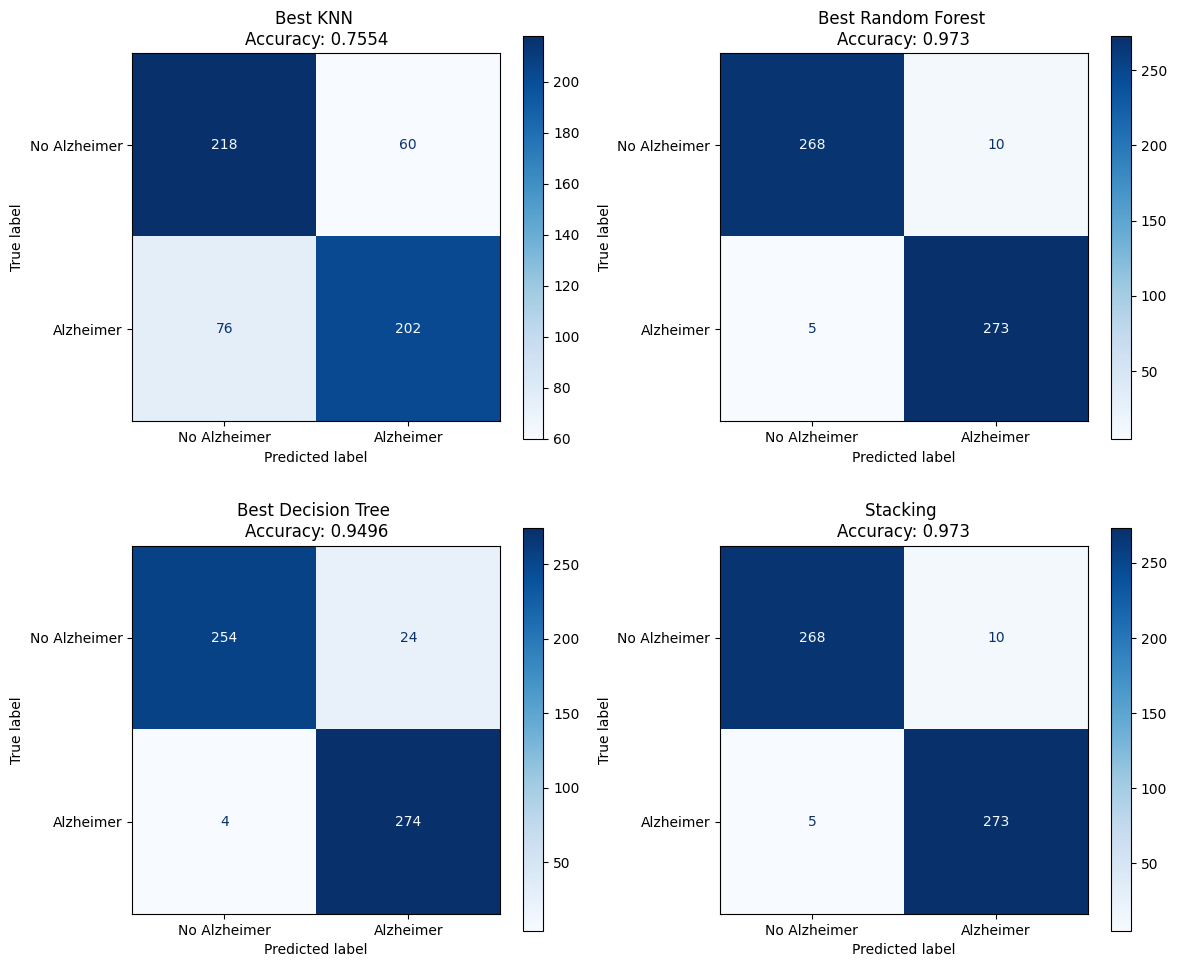

In [165]:
def plot_confusion_matrices(y_test_knn, knn_pred, knn_acc,
                              y_test_rf, rf_pred, rf_acc,
                              y_test_dt, dt_pred, dt_acc,
                              y_test_stack, stack_pred, stack_acc):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    display_labels = ['No Alzheimer', 'Alzheimer']

    # KNN
    cm_knn = confusion_matrix(y_test_knn, knn_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=display_labels).plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('Best KNN \nAccuracy: ' + str(round(knn_acc, 4)))

    # Random Forest
    cm_rf = confusion_matrix(y_test_rf, rf_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=display_labels).plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Best Random Forest \nAccuracy: ' + str(round(rf_acc, 4)))

    # Decision Tree
    cm_dt = confusion_matrix(y_test_dt, dt_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=display_labels).plot(ax=axes[2], cmap='Blues')
    axes[2].set_title('Best Decision Tree \nAccuracy: ' + str(round(dt_acc, 4)))

    # Stacking
    cm_stack = confusion_matrix(y_test_stack, stack_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=display_labels).plot(ax=axes[3], cmap='Blues')
    axes[3].set_title('Stacking \nAccuracy: ' + str(round(stack_acc, 4)))

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test_knn, knn_pred_best, knn_acc_best,
                    y_test_rf, rf_pred_best, rf_acc_best,
                    y_test_dt, dt_pred_best, dt_acc_best,
                    y_test_os, stack_pred, stack_acc) 

The confusion matrices give us a detailed view of each model's classification performance on the Alzheimer's dataset.

- KNN
  While it correctly identifies many positive and negative cases, it struggles more than the others, with 60 false positives (No Alzheimer predicted as Alzheimer) and 76 false negatives (Alzheimer predicted as No Alzheimer). This relatively high number of misclassifications leads to the lowest accuracy among the models.

- Random Forest
  This model performs exceptionally well, misclassifying only 10 negatives and 5 positives, showcasing a balanced and precise detection of both classes. It’s highly reliable for both identifying and ruling out Alzheimer’s cases.

- Decision Tree
  Also very strong, with slightly more false positives (24) than Random Forest, but fewer false negatives (4). It offers solid performance with a slight trade-off between precision and recall compared to RF.

- Stacking 
  Matching Random Forest in overall accuracy, the stacking model also produces 10 false positives and 5 false negatives, suggesting that the ensemble successfully consolidates the strengths of individual classifiers. Its balanced performance confirms that combining models can produce a robust and reliable classifier.

### ROC Curves

To assess how well each model distinguishes between patients with and without Alzheimer’s, we plotted the ROC (Receiver Operating Characteristic) curves for the best K-Nearest Neighbors (KNN), Random Forest (RF), and Decision Tree (DT) models, as well as the final stacking classifier.

Each ROC curve shows the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate at various threshold settings. The closer a curve follows the top-left corner, the better the model is at making accurate classifications across different thresholds.

A key metric extracted from the ROC curve is the Area Under the Curve (AUC). This value ranges from 0.5 (no discrimination, equivalent to random guessing) to 1.0 (perfect classification). A higher AUC indicates a better-performing model.

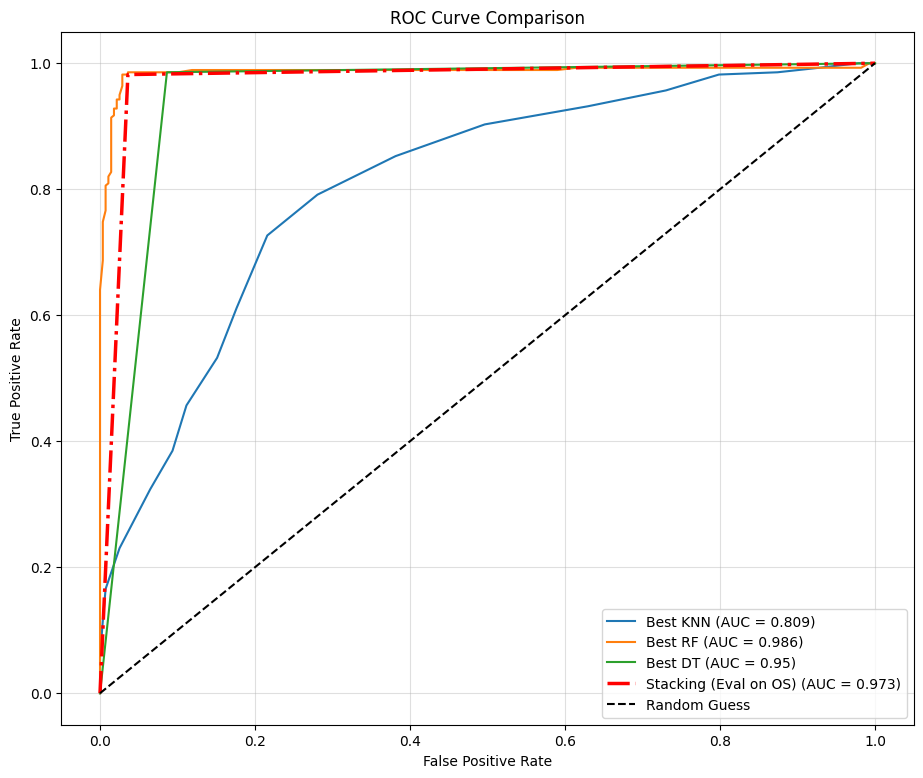

In [166]:
def plot_roc_curves(knn_model, X_test_knn, y_test_knn, knn_dataset_type,
                      rf_model, X_test_rf, y_test_rf, rf_dataset_type,
                      dt_model, X_test_dt, y_test_dt, dt_dataset_type,
                      y_test_stack, stack_probs_param):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(11, 9))

    knn_probs = knn_model.predict_proba(X_test_knn)[:, 1]
    rf_probs = rf_model.predict_proba(X_test_rf)[:, 1]
    dt_probs = dt_model.predict_proba(X_test_dt)[:, 1]

    knn_fpr, knn_tpr, _ = roc_curve(y_test_knn, knn_probs)
    knn_auc = auc(knn_fpr, knn_tpr)
    rf_fpr, rf_tpr, _ = roc_curve(y_test_rf, rf_probs)
    rf_auc = auc(rf_fpr, rf_tpr)
    dt_fpr, dt_tpr, _ = roc_curve(y_test_dt, dt_probs)
    dt_auc = auc(dt_fpr, dt_tpr)
    stack_fpr, stack_tpr, _ = roc_curve(y_test_stack, stack_probs_param)
    stack_auc = auc(stack_fpr, stack_tpr)

    plt.plot(knn_fpr, knn_tpr, label='Best KNN (AUC = ' + str(round(knn_auc, 3)) + ')')
    plt.plot(rf_fpr, rf_tpr, label='Best RF (AUC = ' + str(round(rf_auc, 3)) + ')')
    plt.plot(dt_fpr, dt_tpr, label='Best DT (AUC = ' + str(round(dt_auc, 3)) + ')')
    plt.plot(stack_fpr, stack_tpr, label='Stacking (Eval on OS) (AUC = ' + str(round(stack_auc, 3)) + ')', linewidth=2.5, linestyle='-.', color='red')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

plot_roc_curves(knn_best, X_test_scaled_knn, y_test_knn, knn_dataset_type,
                rf_best, X_test_scaled_rf, y_test_rf, rf_dataset_type,
                dt_best, X_test_scaled_dt, y_test_dt, dt_dataset_type,
                y_test_os, stack_pred)

K-Nearest Neighbors: This model shows the weakest performance. The curve rises more gradually, meaning that KNN struggles to distinguish between Alzheimer and non-Alzheimer cases. Its predictive power is limited, with more trade-offs between sensitivity and specificity.

Decision Tree: Stronger performance with a curve that quickly approaches the top-left corner, indicating a good balance between true positive and false positive rates. It is much more reliable than KNN but slightly underperforms compared to more complex ensembles.

Random Forest: Outstanding classification capability. The curve nearly touches the top-left corner early on, indicating that the model is able to achieve a high true positive rate with very few false positives. This shows excellent generalization.

Stacking: This ensemble method also achieves near-perfect performance, very close to Random Forest. Although its AUC is marginally lower, it still demonstrates superior predictive ability. It benefits from combining multiple models’ strengths.


### Conclusion

The comparative analysis shows that ensemble methods—particularly Random Forest and Stacking—outperform individual models in detecting Alzheimer’s cases. Random Forest achieves the highest AUC (0.986) and test accuracy (97.3%), with excellent balance between sensitivity and specificity as shown in its confusion matrix. Stacking, while slightly behind Random Forest in terms of AUC (0.973) and accuracy, still performs strongly, surpassing both KNN (AUC = 0.809) and Decision Tree (AUC = 0.950).

However, the marginal improvement offered by stacking over Random Forest alone (essentially none in test accuracy) suggests that it may not be worth the additional complexity in this specific context. Stacking becomes more justifiable when individual base models contribute diverse and complementary strengths.

In summary, Random Forest is the most effective and efficient choice.